## SEIRS Model - Adaptive Iterative Sequential Data-Consistent Parameter Estimation 

**Problem description**:

The SEIRS model describes the spread of a disease in a population fixed to $N$ individuals over time $t$. Furthermore, the model divides the population into four categories, called "S", "E", "I", and "R". The extra "S" at the end usually means we include the loss of immunity.
- "S" consists of individuals who are susceptible to the disease being modeled.
- "E" consists of individuals who are exposed to the disease. Diseases (like COVID-19) often have an incubation period or a latency period and this category accommodates it. (The SIR model does not have this category.)
- "I" consists of individuals infected with the disease and are capable of infecting others.
- "R" consists of individuals who can be removed from the system, e.g., because they have gained immunity to the disease, or because they have succumbed to the disease.

The SEIR model, like many other epidemiological models depends on particular parameters, which are the following :
 - $\beta>0$ The rate of contraction of the disease (transmission parameter)
 - $ \sigma >0$ The incubation rate i.e. the rate at which exposed hosts become infected
 - $\gamma>0$ : The mean recovery rate
 - $\xi>0$ : The loss of immunity rate. 
 
Individual $S$ becomes infected after positive contact with an $I$ individual. However, he develops immunity to the disease : he leaves $I$ category at a $\gamma$ cure rate. However with a rate $\xi$, they may lose immunity to the disease and rejoin the susceptible population $S$.

**Model Assumptions**

- Model is deterministic
- On average, an individual $S$ in the population encounters $\beta$ individuals per unit time.
- The rate of infected individuals leaving category $I$ is $\gamma I$ per unit time (once an individual has been infected, he develops immunity to the disease).
- The population size $N=S+E+I+R$ is constant.
- Note constant average number of contacts $\beta$ is a strong and constraining assumption : it cannot be applied to all diseases.

This is the system of equations of the model :

The total population $N$ in the system (the sum of individuals in all categories) is likely to be quite large. Instead of working with such large numbers, let us divide each side of each equation by $\mathbf{N}$ and work instead with the proportions
$$
s=\frac{S}{N}, \quad e=\frac{E}{N}, \quad i=\frac{I}{N}, \quad r=\frac{R}{N} .
$$
The equivalent ODE system to be solved for the unknown functions $s(t), e(t), i(t)$, and $r(t)$, has now become
$$
\begin{aligned}
& \frac{d s}{d t}=-\beta i s  + \xi r\\
& \frac{d e}{d t}=\beta i s-\sigma e \\
& \frac{d i}{d t}=\sigma e-\gamma i \\
& \frac{d r}{d t}=\gamma i - \xi r
\end{aligned}
$$
When supplemented with some initial conditions, say
$$
s(0)=0.99, \quad e(0)=0.01, \quad i(0)=0, \quad r(0)=0
$$
This is the formulation of the Initial Value Probelm we wish to solve. Note that the above initial conditions correspond to a starting scenario where just $1 \%$ of the population is exposed.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pydci.examples import seirs
import importlib
from pydci.log import enable_log, disable_log
from pydci.utils import get_l2_errs, set_seed

importlib.reload(seirs)


SEIRS_PARAM_MINS = 4 * [0]
SEIRS_STATE_MINS = 1e-10
SEIRS_STATE_MAXS = 1

# For periodic behavior
R_0 = 3

# Sample every week
SEIRS_SAMPLE_TS = 1

# Populations are all from 0-1 -> Fraction of population
SEIRS_NOISE = 0.001

# Parameters from bjornstad2020seirs paper
SEIRS_P1 = [
    R_0 / 14.0,  # beta transmission rate - R_0 / gamma -> R_0 > 0 for periodic behavior
    1.0 / 7.0,  # sigma incubation rate i.e. rate at which exposed hosts become infected - 1 week
    1.0 / 14.0,  # gamma  mean recovery rate - 2 weeks
    1.0 / 365.0,  # xi - loss off imunity rate - 1 year
]

# (1) Policy Lockdown 1 month in: => Slower Transmission Rate(beta) - Time 75
SEIRS_P2 = [
    0.5 * R_0 / 14.0,  # transmission rate halved
    1.0 / 7.0,  # sigm
    1.0 / 14.0,
    1.0 / 365.0,
]
# (2) Virus Mutation 1 year in: => Faster Incubation Rate (sigma) - Time 150
SEIRS_P3 = [
    1.2 * R_0 / 14.0,  # transmission rate increased -> Faster transmitting virus
    1.0 / 3.5,  # Incubation rate halved -> Exposed hosts become infected quicker
    1.0 / 14.0,
    1.0 / 365.0,
]

SEIRS_X0 = [
    0.98,  # susceptible
    0.010,  # exposed
    0.010,  # infected
    0,  # recovered
]

# enable_log(level='DEBUG')
n_samples = 1000
total_time = 1 * 365.25
param_shifts = {0: SEIRS_P1, 25: SEIRS_P2, 150: SEIRS_P3}

## Problem Set-Up

<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

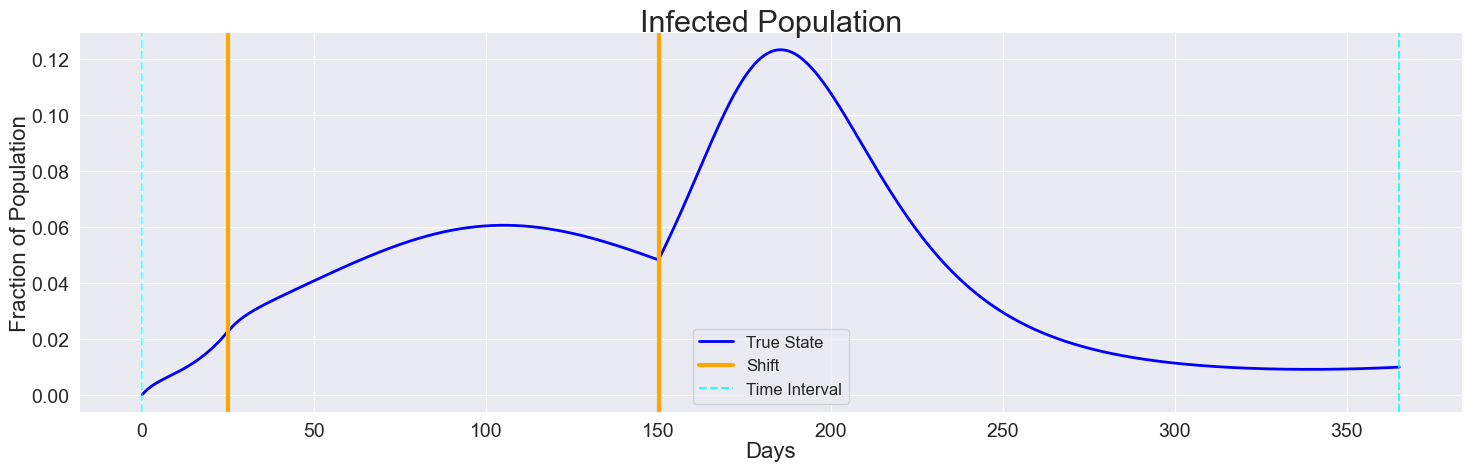

In [2]:
full_sr = seirs.SEIRSModel(
    lam_true=SEIRS_P1,
    param_shifts=param_shifts,
    measurement_noise=SEIRS_NOISE,
    sample_ts=SEIRS_SAMPLE_TS,
    state_mins=SEIRS_STATE_MINS,
    state_maxs=SEIRS_STATE_MAXS,
)
# pi_in, samples = full_sr.get_uniform_initial_samples(num_samples=1, scale=0.1)
res = full_sr.get_data(t0=0.0, tf=total_time)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
full_sr.plot_infected(plot_samples=False, plot_measurements=False, ax=ax)

# Online Iterative

In [3]:
total_time = 1 * 365.25
max_nc = 1
data_chunk_size = 14
n_chunks = int(total_time / data_chunk_size)

sr = seirs.SEIRSModel(
    lam_true=SEIRS_P1,
    param_shifts=param_shifts,
    measurement_noise=2*SEIRS_NOISE,
    sample_ts=SEIRS_SAMPLE_TS,
    state_mins=SEIRS_STATE_MINS,
    state_maxs=SEIRS_STATE_MAXS,
)

In [4]:
from pydci.log import logger
from pydci.utils import get_search_combinations
import pydci.consistent_bayes.OnlineSequential as os
import importlib

importlib.reload(os)
prob = os.OnlineSequential(
    sr,
    time_step=data_chunk_size,
)
enable_log(level='DEBUG', filter='pydci.consistent_bayes.OnlineSequential')
prob.solve(
    num_its=52,
    max_t=None,
    num_samples=1000,
    max_sample_size=2000,
    samples_inc=None,
    time_step=data_chunk_size,
    exp_thresh=0.1,
    kl_thresh=3.0,
    min_eff_sample_size=0.9,
    num_tries_per_it=2,
    sampling_args={
        "dist": "uniform",
        "scale": 1.0,
    },
    solver_args=dict(
        pca_range=[1, 2, 3],
        split_range=[1],
        all_data=True,
    ),
    make_plots=False,
    seed=2023,
    reset_model=True,
    reset_samples=False,
)

[08/15/23 23:24:44] INFO     Setting seed to 2023                                           ]8;id=748519;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=761215;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#601\601]8;;\

                    INFO     No previous data -> Starting from initial                      ]8;id=603612;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=534793;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#606\606]8;;\

                    DEBUG    make_plots: False                                              ]8;id=532782;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=281717;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#644\644]8;;\

                    INFO     Starting online solve with 1000 samples                        ]8;id=530079;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=677357;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#648\648]8;;\

                    DEBUG    Getting measurements over time window 0 to 14                  ]8;id=873224;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=737061;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 0                                ]8;id=805758;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=633307;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=814987;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=858860;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Starting from initial Reset:False, Data_Idx: 0                 ]8;id=793606;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=628017;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#493\493]8;;\
                             Sampling Args: {'dist': 'uniform', 'scale': 1.0}                                      
                             Solver Args: {'pca_range': [1, 2, 3], 'split_range': [1],                             
                             'all_data': True}                                                                     

                    INFO     Advancing forward model for 1000 samples                       ]8;id=679327;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=158403;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=85860;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=207250;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True}                                             

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=24813;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=769984;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.064890  1.165099    1.0     0.674    True                                        
                             0  1.053699  1.378902    1.0     0.628    True                                        
                             0  0.681434  1.568474    1.0     0.617   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.091823   0.048413                                                                   
                             0                                               None                                  
                             0.125756   0.084810                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.228080   0.095228                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.014929   0.004186  ...  1            0      0.064890                            
                             True                                                                                  
                             0   0.047641   0.000646  ...  1            1      0.053699                            
                             True                                                                                  
                             0   0.102136   0.004032  ...  1            2      0.318566                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True    False   False    True         1000     False                              
                             0   True     True    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 14 to 28                 ]8;id=426385;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=787881;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 1                                ]8;id=802217;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=640462;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=909105;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=705484;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.628 < 0.9).                              ]8;id=37128;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=846223;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_0                                       ]8;id=719228;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=137839;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=137068;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=245641;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=581787;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=546292;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=255778;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=287742;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0  1.011087  1.969130    1.0     0.501    True  None                                  
                             0.122931   0.119254                                                                   
                             0  1.067143  2.809673    1.0     0.374    True  None                                  
                             0.134990   0.168156                                                                   
                             0  1.044881  2.900538    1.0     0.361    True  None                                  
                             0.134990   0.168156                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.051051   0.002851  ...  1            0      0.011087                            
                             True                                                                                  
                             0   0.042119   0.004536  ...  1            1      0.067143                            
                             True                                                                                  
                             0   0.042119   0.004536  ...  1            2      0.044881                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False   False   False         1000     False                              
                             0   True    False    True   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 28 to 42                 ]8;id=873344;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=301992;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 2                                ]8;id=632475;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=791792;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=308875;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=871396;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.501 < 0.9).                              ]8;id=868592;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=822700;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_1                                       ]8;id=525497;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=540185;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=561655;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=548965;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

[08/15/23 23:24:45] DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=869568;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=727155;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=624462;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=500339;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.041777  2.301643    1.0     0.313    True                                        
                             0  1.121004  3.422816    1.0     0.203   False                                        
                             0  1.146767  4.155320    1.0     0.193   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.057788   0.197900                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.004947   0.173825                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.135663   0.104882                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.049074   0.003845  ...  1            0      0.041777                            
                             True                                                                                  
                             0   0.025941   0.001647  ...  1            1      0.121004                            
                             True                                                                                  
                             0   0.080711   0.002321  ...  1            2      0.146767                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True    True    True         1000     False                              
                             0  False    False   False   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 42 to 56                 ]8;id=270274;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=585904;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 3                                ]8;id=930029;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=717509;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=726307;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=322863;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.313 < 0.9).                              ]8;id=310522;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=339036;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_2                                       ]8;id=262614;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=177177;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=365736;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=144399;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=836474;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=701514;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=725555;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=623876;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.084050  1.775749    1.0     0.432    True                                        
                             0  1.348616  2.531312    1.0     0.312   False                                        
                             0  1.439908  2.546573    1.0     0.302   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.114389   0.143514                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.108044   0.174182                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.230380   0.180549                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.075088   0.003347  ...  1            0      0.084050                            
                             True                                                                                  
                             0   0.075984   0.002987  ...  1            1      0.348616                            
                             True                                                                                  
                             0   0.146667   0.003544  ...  1            2      0.439908                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True    True    True         1000     False                              
                             0  False    False   False   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 56 to 70                 ]8;id=740387;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=639117;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 4                                ]8;id=110947;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=921196;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=944505;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=599639;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.432 < 0.9).                              ]8;id=896888;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=438081;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_3                                       ]8;id=745357;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=759652;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=167654;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=357584;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=956847;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=720390;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=689918;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=754405;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0  1.048741  1.542253    1.0     0.511    True  None                                  
                             0.122354   0.122736                                                                   
                             0  0.937890  2.618129    1.0     0.351    True  None                                  
                             0.109429   0.185472                                                                   
                             0  0.966016  2.947797    1.0     0.338    True  None                                  
                             0.122354   0.122736                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.078810   0.001654  ...  1            0      0.048741                            
                             True                                                                                  
                             0   0.077623   0.006496  ...  1            1      0.062110                            
                             True                                                                                  
                             0   0.078810   0.001654  ...  1            2      0.033984                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True    False   False    True         1000     False                              
                             0   True    False   False   False         1000     False                              
                             0   True     True    True   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 70 to 84                 ]8;id=678929;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=450999;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 5                                ]8;id=212424;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=523480;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=784127;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=348323;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.338 < 0.9).                              ]8;id=23654;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=115341;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_4                                       ]8;id=537419;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=400187;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=322425;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=782928;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=404454;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=690013;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

[08/15/23 23:24:46] INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=135886;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=842306;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  0.991050  1.706971    1.0     0.565    True                                        
                             0  1.159763  2.149035    1.0     0.552   False                                        
                             0  0.791264  3.348210    1.0     0.522   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.137432   0.105249                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.146272   0.137587                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.088608   0.188271                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.074031   0.002667  ...  1            0      0.008950                            
                             True                                                                                  
                             0   0.091452  -0.000509  ...  1            1      0.159763                            
                             True                                                                                  
                             0   0.078388   0.004851  ...  1            2      0.208736                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True    True    True         1000     False                              
                             0  False    False   False   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 84 to 98                 ]8;id=451300;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=966940;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 6                                ]8;id=393500;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=873248;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=408149;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=868785;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.565 < 0.9).                              ]8;id=943812;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=262719;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_5                                       ]8;id=702281;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=48058;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=230923;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=629938;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=198994;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=825780;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=475189;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=552269;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0  1.010235  1.018070    1.0     0.787    True  None                                  
                             0.118248   0.117267                                                                   
                             0  1.040000  1.478084    1.0     0.745    True  None                                  
                             0.118248   0.117267                                                                   
                             0  1.001145  1.659597    1.0     0.737    True  None                                  
                             0.159850   0.096108                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.070077   0.002018  ...  1            0      0.010235                            
                             True                                                                                  
                             0   0.070077   0.002018  ...  1            1      0.040000                            
                             True                                                                                  
                             0   0.074146   0.002443  ...  1            2      0.001145                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True    False   False    True         1000     False                              
                             0   True    False   False   False         1000     False                              
                             0   True     True    True   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 98 to 112                ]8;id=92542;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=442161;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 7                                ]8;id=897738;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=908469;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=725019;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=10257;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.737 < 0.9).                              ]8;id=525716;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=29976;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_6                                       ]8;id=741913;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=879670;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=858760;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=375270;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=660920;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=389578;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=446202;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=759239;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.028660  1.533415    1.0     0.719    True                                        
                             0  1.049153  1.629737    1.0     0.710    True                                        
                             0  0.714525  2.257779    1.0     0.702   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.137661   0.096935                                                                   
                             0                                               None                                  
                             0.137661   0.096935                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.037853   0.097576                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.068511   0.001569  ...  1            0      0.028660                            
                             True                                                                                  
                             0   0.068511   0.001569  ...  1            1      0.049153                            
                             True                                                                                  
                             0   0.037246  -0.000353  ...  1            2      0.285475                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 112 to 126               ]8;id=277152;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=168226;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 8                                ]8;id=24157;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=414322;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=860823;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=604203;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.719 < 0.9).                              ]8;id=310316;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=537315;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_7                                       ]8;id=846338;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=578986;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=312794;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=445662;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=105930;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=340168;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=889208;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=289137;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0  0.999174  1.076074    1.0     0.799    True  None                                  
                             0.114143   0.089058                                                                   
                             0  1.010616  1.449803    1.0     0.784    True  None                                  
                             0.114143   0.089058                                                                   
                             0  0.916306  1.560563    1.0     0.779    True  None                                  
                             0.111584   0.152207                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.057650   0.003016  ...  1            0      0.000826                            
                             True                                                                                  
                             0   0.057650   0.003016  ...  1            1      0.010616                            
                             True                                                                                  
                             0   0.076881   0.004622  ...  1            2      0.083694                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False   False   False         1000     False                              
                             0   True    False    True   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 126 to 140               ]8;id=376890;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=670235;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 9                                ]8;id=394322;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=162115;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=670770;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=894172;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.799 < 0.9).                              ]8;id=522070;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=935621;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_8                                       ]8;id=215061;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=133874;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=867660;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=600276;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

[08/15/23 23:24:47] DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=432270;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=940009;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=182629;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=550716;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.056252  0.832917    1.0     0.849    True                                        
                             0  1.127364  1.088951    1.0     0.816   False                                        
                             0  0.759239  2.452614    1.0     0.792   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.104722   0.084345                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.104722   0.084345                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.023214   0.109475                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.049964   0.006219  ...  1            0      0.056252                            
                             True                                                                                  
                             0   0.049964   0.006219  ...  1            1      0.127364                            
                             True                                                                                  
                             0   0.037823  -0.000243  ...  1            2      0.240761                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True    True    True         1000     False                              
                             0  False    False   False   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 140 to 154               ]8;id=56310;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=880500;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 10                               ]8;id=301494;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=744048;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=568175;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=874786;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.849 < 0.9).                              ]8;id=243042;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=408246;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_9                                       ]8;id=59012;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=137977;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=346201;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=305889;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=47194;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=743364;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=266181;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=196596;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  0.990509  1.364210    1.0     0.773    True                                        
                             0  0.881969  2.975272    1.0     0.636   False                                        
                             0  0.103205  3.171485    1.0     0.577   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.115871   0.093506                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.101458   0.070275                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.119901   0.064667                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.057346   0.006387  ...  1            0      0.009491                            
                             True                                                                                  
                             0   0.040441   0.007292  ...  1            1      0.118031                            
                             True                                                                                  
                             0   0.044699   0.008656  ...  1            2      0.896795                            
                             False                                                                                 
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True    True    True         1000     False                              
                             0  False    False   False   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 154 to 168               ]8;id=659195;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=571491;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 11                               ]8;id=457014;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=728636;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=700001;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=46918;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.773 < 0.9).                              ]8;id=997128;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=677158;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_10                                      ]8;id=250435;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=904966;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=4096;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=391770;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=600761;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=515782;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    DEBUG    Failed with 1000 samples:                                      ]8;id=878552;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=459131;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#523\523]8;;\
                                          e_r         kl  k_eff  k_eff_up  solved  \                               
                             0  7.925144e-151  11.467406    1.0       0.0   False                                  
                             0  2.043991e-236  10.725029    1.0       0.0   False                                  
                             0  2.809314e-239   9.837123    1.0       0.0   False                                  
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.020262   0.064671                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.018766   0.013863                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.018766   0.013863                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...      pca_mask  i  I  search_index                        
                             predict_delta  \                                                                      
                             0   0.019398   0.000413  ...  range(0, 15)  1  1             0                        
                             1.0                                                                                   
                             0   0.000643   0.003694  ...  range(0, 15)  1  1             1                        
                             1.0                                                                                   
                             0   0.000643   0.003694  ...  range(0, 15)  1  1             2                        
                             1.0                                                                                   
                                                                                                                   
                                within_thresh  valid  closest  max_kl  min_kl                                      
                             0          False  False    False   False   False                                      
                             0          False  False    False   False   False                                      
                             0          False  False    False   False   False                                      
                                                                                                                   
                             [3 rows x 22 columns]                                                                 

                    DEBUG    Drawing 100 more samples.                                      ]8;id=199489;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=880551;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#547\547]8;;\

                    DEBUG    Solving forward model for 100 more samples                     ]8;id=900081;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=894010;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#550\550]8;;\

                    DEBUG    Solving UN-WEIGHTED 1100 samples. Args: {'pca_range': [1, 2,   ]8;id=264031;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=258624;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

[08/15/23 23:24:48] DEBUG    Failed with 1100 samples:                                      ]8;id=535889;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=387794;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#523\523]8;;\
                                     e_r         kl  k_eff  k_eff_up  solved  \                                    
                             0  0.640471  10.342112    1.0  0.009091   False                                       
                             0  0.738005  10.417053    1.0  0.008182   False                                       
                             0  0.193953  10.577589    1.0  0.005455   False                                       
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.166191   0.168175                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.166191   0.168175                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.146969   0.266719                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...      pca_mask  i  I  search_index                        
                             predict_delta  \                                                                      
                             0   0.027697   0.002252  ...  range(0, 15)  1  1             0                        
                             0.359529                                                                              
                             0   0.027697   0.002252  ...  range(0, 15)  1  1             1                        
                             0.261995                                                                              
                             0   0.037722   0.004048  ...  range(0, 15)  1  1             2                        
                             0.806047                                                                              
                                                                                                                   
                                within_thresh  valid  closest  max_kl  min_kl                                      
                             0           True  False    False   False   False                                      
                             0           True  False    False   False   False                                      
                             0          False  False    False   False   False                                      
                                                                                                                   
                             [3 rows x 22 columns]                                                                 

                    DEBUG    Drawing 100 more samples.                                      ]8;id=666151;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=774818;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#547\547]8;;\

                    DEBUG    Solving forward model for 100 more samples                     ]8;id=740422;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=153284;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#550\550]8;;\

                    DEBUG    Solving UN-WEIGHTED 1200 samples. Args: {'pca_range': [1, 2,   ]8;id=7078;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=694720;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    DEBUG    Failed with 1200 samples:                                      ]8;id=992876;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=265043;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#523\523]8;;\
                                     e_r         kl  k_eff  k_eff_up  solved  \                                    
                             0  0.580482   9.845377    1.0  0.010833   False                                       
                             0  0.806941   9.863353    1.0  0.010000   False                                       
                             0  0.311365  10.226611    1.0  0.007500   False                                       
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.166191   0.168175                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.166191   0.168175                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.146969   0.266719                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...      pca_mask  i  I  search_index                        
                             predict_delta  \                                                                      
                             0   0.027697   0.002252  ...  range(0, 15)  1  1             0                        
                             0.419518                                                                              
                             0   0.027697   0.002252  ...  range(0, 15)  1  1             1                        
                             0.193059                                                                              
                             0   0.037722   0.004048  ...  range(0, 15)  1  1             2                        
                             0.688635                                                                              
                                                                                                                   
                                within_thresh  valid  closest  max_kl  min_kl                                      
                             0           True  False    False   False   False                                      
                             0           True  False    False   False   False                                      
                             0          False  False    False   False   False                                      
                                                                                                                   
                             [3 rows x 22 columns]                                                                 

                    DEBUG    Drawing 100 more samples.                                      ]8;id=251872;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=749538;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#547\547]8;;\

                    DEBUG    Solving forward model for 100 more samples                     ]8;id=595703;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=520415;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#550\550]8;;\

                    DEBUG    Solving UN-WEIGHTED 1300 samples. Args: {'pca_range': [1, 2,   ]8;id=87618;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=937311;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    DEBUG    Failed with 1300 samples:                                      ]8;id=463778;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=594431;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#523\523]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  0.826756  8.847225    1.0  0.016154   False                                        
                             0  1.151882  8.792613    1.0  0.013077   False                                        
                             0  0.557799  9.681355    1.0  0.010769   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.166191   0.168175                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.166191   0.168175                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.146969   0.266719                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...      pca_mask  i  I  search_index                        
                             predict_delta  \                                                                      
                             0   0.027697   0.002252  ...  range(0, 15)  1  1             0                        
                             0.173244                                                                              
                             0   0.027697   0.002252  ...  range(0, 15)  1  1             1                        
                             0.151882                                                                              
                             0   0.037722   0.004048  ...  range(0, 15)  1  1             2                        
                             0.442201                                                                              
                                                                                                                   
                                within_thresh  valid  closest  max_kl  min_kl                                      
                             0           True  False    False   False   False                                      
                             0           True  False    False   False   False                                      
                             0           True  False    False   False   False                                      
                                                                                                                   
                             [3 rows x 22 columns]                                                                 

                    DEBUG    Drawing 100 more samples.                                      ]8;id=438983;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=183498;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#547\547]8;;\

                    DEBUG    Solving forward model for 100 more samples                     ]8;id=772093;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=421364;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#550\550]8;;\

                    DEBUG    Solving UN-WEIGHTED 1400 samples. Args: {'pca_range': [1, 2,   ]8;id=924000;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=576965;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1400). Results:                          ]8;id=790252;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=565967;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                          e_r         kl  k_eff  k_eff_up  solved  \                               
                             0  7.925144e-151  11.467406    1.0  0.000000   False                                  
                             0  2.043991e-236  10.725029    1.0  0.000000   False                                  
                             0  2.809314e-239   9.837123    1.0  0.000000   False                                  
                             0   6.404711e-01  10.342112    1.0  0.009091   False                                  
                             0   7.380055e-01  10.417053    1.0  0.008182   False                                  
                             0   1.939529e-01  10.577589    1.0  0.005455   False                                  
                             0   5.804820e-01   9.845377    1.0  0.010833   False                                  
                             0   8.069414e-01   9.863353    1.0  0.010000   False                                  
                             0   3.113653e-01  10.226611    1.0  0.007500   False                                  
                             0   8.267555e-01   8.847225    1.0  0.016154   False                                  
                             0   1.151882e+00   8.792613    1.0  0.013077   False                                  
                             0   5.577995e-01   9.681355    1.0  0.010769   False                                  
                             0   1.002413e+00   7.874971    1.0  0.023571    True                                  
                             0   1.008025e+00   8.175804    1.0  0.020000    True                                  
                             0   5.848493e-01   9.210509    1.0  0.016429   False                                  
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.020262   0.064671                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.018766   0.013863                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.018766   0.013863                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.166191   0.168175                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.166191   0.168175                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.146969   0.266719                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)..

                    DEBUG    Getting measurements over time window 168 to 182               ]8;id=829984;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=295270;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 12                               ]8;id=808197;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=334991;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=367647;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=918965;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.023571428571428573 < 0.9).               ]8;id=629064;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=391574;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_11                                      ]8;id=146814;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=964088;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=493435;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=539110;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=271418;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=115073;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

[08/15/23 23:24:49] INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=393314;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=808967;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  0.872294  2.803870    1.0     0.235   False                                        
                             0  1.082738  3.029690    1.0     0.198    True                                        
                             0  0.897668  3.374206    1.0     0.180   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.215980   0.230511                                                                   
                             0                                               None                                  
                             0.176710   0.194840                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.094783   0.205853                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.055653   0.002367  ...  1            0      0.127706                            
                             True                                                                                  
                             0   0.042855   0.000390  ...  1            1      0.082738                            
                             True                                                                                  
                             0   0.027283   0.003670  ...  1            2      0.102332                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0  False    False   False   False         1000     False                              
                             0   True     True    True    True         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 182 to 196               ]8;id=868840;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=741937;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 13                               ]8;id=872053;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=910532;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=911188;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=560797;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.198 < 0.9).                              ]8;id=297031;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=79934;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_12                                      ]8;id=815897;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=467586;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=656697;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=580734;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=21539;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=569225;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=644957;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=849292;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  0.936784  1.989640    1.0     0.407    True                                        
                             0  0.922914  2.654158    1.0     0.378    True                                        
                             0  0.679811  2.806343    1.0     0.343   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.258538   0.280669                                                                   
                             0                                               None                                  
                             0.267173   0.262781                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.290171   0.326751                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.071490   0.006112  ...  1            0      0.063216                            
                             True                                                                                  
                             0   0.073938   0.004513  ...  1            1      0.077086                            
                             True                                                                                  
                             0   0.084295   0.007918  ...  1            2      0.320189                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 196 to 210               ]8;id=993175;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=269434;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 14                               ]8;id=447711;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=688262;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=815974;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=247478;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.407 < 0.9).                              ]8;id=872708;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=324285;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_13                                      ]8;id=999685;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=460584;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=176977;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=315129;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=881049;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=750539;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=775102;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=147586;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.038021  1.021679    1.0     0.723    True                                        
                             0  0.910567  1.712926    1.0     0.685    True                                        
                             0  0.814383  1.838559    1.0     0.668   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.253721   0.262947                                                                   
                             0                                               None                                  
                             0.260786   0.279824                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.281655   0.276440                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.069622   0.003765  ...  1            0      0.038021                            
                             True                                                                                  
                             0   0.076044   0.006106  ...  1            1      0.089433                            
                             True                                                                                  
                             0   0.075976   0.001749  ...  1            2      0.185617                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 210 to 224               ]8;id=371628;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=932646;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 15                               ]8;id=161269;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=179745;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=298346;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=299976;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.723 < 0.9).                              ]8;id=534636;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=297943;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_14                                      ]8;id=672423;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=204712;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=939713;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=594995;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=677654;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=279618;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=142063;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=967238;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.034245  0.876653    1.0     0.857    True                                        
                             0  1.073077  1.062218    1.0     0.844    True                                        
                             0  0.848831  1.186680    1.0     0.835   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.245474   0.270391                                                                   
                             0                                               None                                  
                             0.278419   0.283763                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.263409   0.301482                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.069594   0.004034  ...  1            0      0.034245                            
                             True                                                                                  
                             0   0.074375   0.004367  ...  1            1      0.073077                            
                             True                                                                                  
                             0   0.075243   0.002808  ...  1            2      0.151169                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 224 to 238               ]8;id=125277;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=959442;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 16                               ]8;id=320324;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=19074;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=91398;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=208098;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.857 < 0.9).                              ]8;id=864337;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=332144;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_15                                      ]8;id=269598;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=479662;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=545124;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=962229;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

[08/15/23 23:24:50] DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=964863;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=2549;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=354463;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=899145;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.018233  0.707832    1.0     0.935    True                                        
                             0  0.942993  1.083898    1.0     0.932    True                                        
                             0  0.393359  1.406746    1.0     0.921   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.280789   0.260018                                                                   
                             0                                               None                                  
                             0.283843   0.228000                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.305544   0.186709                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.074491   0.004164  ...  1            0      0.018233                            
                             True                                                                                  
                             0   0.068921   0.002457  ...  1            1      0.057007                            
                             True                                                                                  
                             0   0.066052   0.002815  ...  1            2      0.606641                            
                             False                                                                                 
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 238 to 252               ]8;id=653995;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=349950;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 17                               ]8;id=646192;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=487485;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=488158;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=335608;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Using samples 1000 from previous iteration 16: 0.935 >=0.9).   ]8;id=836174;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=91434;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#486\486]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=436136;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=261423;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving WEIGHTED 1000 samples. Args: {'pca_range': [1, 2, 3],  ]8;id=891449;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=550380;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             'split_range': [1], 'all_data': True, 'search_exp_thresh':                            
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=363141;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=49804;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  0.991667  1.079533  0.935     0.684    True                                        
                             0  0.934885  1.244717  0.935     0.688    True                                        
                             0  0.155553  2.433275  0.935     0.700   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.289957   0.259093                                                                   
                             0                                               None                                  
                             0.289957   0.259093                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.279273   0.278151                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.073650   0.001245  ...  1            0      0.008333                            
                             True                                                                                  
                             0   0.073650   0.001245  ...  1            1      0.065115                            
                             True                                                                                  
                             0   0.073995   0.002416  ...  1            2      0.844447                            
                             False                                                                                 
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000      True                              
                             0   True    False    True   False         1000      True                              
                             0  False    False   False   False         1000      True                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 252 to 266               ]8;id=416704;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=710473;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 18                               ]8;id=46110;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=452356;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=85473;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=370050;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.684 < 0.9).                              ]8;id=214823;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=691871;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_17                                      ]8;id=966535;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=348492;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=858857;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=315634;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=643406;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=778653;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=829313;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=278532;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.019147  0.690130    1.0     0.933    True                                        
                             0  0.940477  1.015681    1.0     0.929    True                                        
                             0  0.033123  1.118414    1.0     0.906   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.270639   0.248314                                                                   
                             0                                               None                                  
                             0.291510   0.224548                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.241260   0.170096                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.070091   0.000450  ...  1            0      0.019147                            
                             True                                                                                  
                             0   0.069579  -0.000885  ...  1            1      0.059523                            
                             True                                                                                  
                             0   0.056719  -0.004092  ...  1            2      0.966877                            
                             False                                                                                 
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 266 to 280               ]8;id=408468;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=970915;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 19                               ]8;id=73188;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=896864;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=741205;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=127266;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Using samples 1000 from previous iteration 18: 0.933 >=0.9).   ]8;id=821273;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=382120;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#486\486]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=306539;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=898723;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving WEIGHTED 1000 samples. Args: {'pca_range': [1, 2, 3],  ]8;id=109516;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=140158;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             'split_range': [1], 'all_data': True, 'search_exp_thresh':                            
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=683687;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=841203;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  0.915052  1.562064  0.933     0.894    True                                        
                             0  0.417340  3.562014  0.933     0.910   False                                        
                             0  0.019762  5.211377  0.933     0.913   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.326121   0.310197                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.298272   0.184034                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.257842   0.240227                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.082585   0.003856  ...  1            0      0.084948                            
                             True                                                                                  
                             0   0.065528  -0.003259  ...  1            1      0.582660                            
                             False                                                                                 
                             0   0.065391  -0.001214  ...  1            2      0.980238                            
                             False                                                                                 
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True    True    True         1000      True                              
                             0  False    False   False   False         1000      True                              
                             0  False    False   False   False         1000      True                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 280 to 294               ]8;id=243619;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=584068;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

[08/15/23 23:24:51] DEBUG    Starting solves for iteration 20                               ]8;id=711649;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=689633;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=54539;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=815199;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.894 < 0.9).                              ]8;id=23852;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=302707;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_19                                      ]8;id=40315;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=201534;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=694813;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=366360;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=452425;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=254623;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=354688;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=163951;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.023486  0.751204    1.0     0.935    True                                        
                             0  0.994222  0.838297    1.0     0.933    True                                        
                             0  0.278816  1.093493    1.0     0.920   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.316251   0.266722                                                                   
                             0                                               None                                  
                             0.324502   0.298362                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.250041   0.396927                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.081093   0.003737  ...  1            0      0.023486                            
                             True                                                                                  
                             0   0.084526   0.004503  ...  1            1      0.005778                            
                             True                                                                                  
                             0   0.083470   0.008555  ...  1            2      0.721184                            
                             False                                                                                 
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True    False   False    True         1000     False                              
                             0   True     True    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 294 to 308               ]8;id=80181;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=735986;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 21                               ]8;id=553836;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=476107;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=907270;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=235674;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Using samples 1000 from previous iteration 20: 0.933 >=0.9).   ]8;id=652387;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=686974;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#486\486]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=44196;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=957346;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving WEIGHTED 1000 samples. Args: {'pca_range': [1, 2, 3],  ]8;id=872804;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=424517;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             'split_range': [1], 'all_data': True, 'search_exp_thresh':                            
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=87275;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=197241;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  0.958605  0.763130  0.933     0.879    True                                        
                             0  0.645373  1.252053  0.933     0.903   False                                        
                             0  0.051529  1.645859  0.933     0.898   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.212183   0.344257                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.324502   0.298362                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.412380   0.158949                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.071041   0.006317  ...  1            0      0.041395                            
                             True                                                                                  
                             0   0.084526   0.004503  ...  1            1      0.354627                            
                             True                                                                                  
                             0   0.080932  -0.002098  ...  1            2      0.948471                            
                             False                                                                                 
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True    True    True         1000      True                              
                             0  False    False   False   False         1000      True                              
                             0  False    False   False   False         1000      True                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 308 to 322               ]8;id=402785;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=707749;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 22                               ]8;id=171316;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=717299;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=308778;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=248949;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.879 < 0.9).                              ]8;id=316134;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=850214;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_21                                      ]8;id=96652;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=215274;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=69078;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=354222;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=595828;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=263323;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=652277;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=498093;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.030028  0.593918    1.0     0.950    True                                        
                             0  0.849560  1.046107    1.0     0.945   False                                        
                             0  0.336570  1.154764    1.0     0.938   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.289572   0.231242                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.272502   0.228010                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.272502   0.228010                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.070600   0.000664  ...  1            0      0.030028                            
                             True                                                                                  
                             0   0.068387  -0.000017  ...  1            1      0.150440                            
                             True                                                                                  
                             0   0.068387  -0.000017  ...  1            2      0.663430                            
                             False                                                                                 
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True    True    True         1000     False                              
                             0  False    False   False   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 322 to 336               ]8;id=224850;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=979820;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 23                               ]8;id=22221;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=78349;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=401125;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=632593;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Using samples 1000 from previous iteration 22: 0.95 >=0.9).    ]8;id=947663;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=1691;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#486\486]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=806385;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=81659;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving WEIGHTED 1000 samples. Args: {'pca_range': [1, 2, 3],  ]8;id=621312;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=382927;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             'split_range': [1], 'all_data': True, 'search_exp_thresh':                            
                             0.1}                                                                                  

[08/15/23 23:24:52] INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=377307;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=176659;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.019843  0.255025   0.95     0.858    True                                        
                             0  0.556934  0.545501   0.95     0.888   False                                        
                             0  0.043944  0.774413   0.95     0.872   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.289572   0.231242                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.219823   0.273789                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.292679   0.087575                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.070600   0.000664  ...  1            0      0.019843                            
                             True                                                                                  
                             0   0.064616   0.001754  ...  1            1      0.443066                            
                             True                                                                                  
                             0   0.056484  -0.006819  ...  1            2      0.956056                            
                             False                                                                                 
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True    True    True         1000      True                              
                             0  False    False   False   False         1000      True                              
                             0  False    False   False   False         1000      True                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 336 to 350               ]8;id=70032;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=931488;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 24                               ]8;id=449310;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=119706;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=168344;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=931016;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.858 < 0.9).                              ]8;id=59806;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=673753;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_23                                      ]8;id=320682;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=94479;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=852588;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=194290;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=672095;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=100570;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=918741;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=304981;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.030744  0.965328    1.0     0.882    True                                        
                             0  1.017013  1.060099    1.0     0.879    True                                        
                             0  0.435299  1.329654    1.0     0.865   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.274186   0.264415                                                                   
                             0                                               None                                  
                             0.275102   0.196461                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.205367   0.323616                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.072821   0.002855  ...  1            0      0.030744                            
                             True                                                                                  
                             0   0.066540   0.000135  ...  1            1      0.017013                            
                             True                                                                                  
                             0   0.068587   0.005784  ...  1            2      0.564701                            
                             False                                                                                 
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True    False   False    True         1000     False                              
                             0   True     True    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 350 to 364               ]8;id=808183;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=509340;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 25                               ]8;id=48300;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=9996;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=625475;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=383330;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.879 < 0.9).                              ]8;id=107210;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=271416;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_24                                      ]8;id=246780;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=601707;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=336564;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=555513;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=769689;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=552068;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=745605;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=597651;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.010787  0.740851    1.0     0.927    True                                        
                             0  1.000444  0.832674    1.0     0.926    True                                        
                             0  0.394107  1.279242    1.0     0.915   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.277307   0.240556                                                                   
                             0                                               None                                  
                             0.277307   0.240556                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.159743   0.373508                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.068840   0.001136  ...  1            0      0.010787                            
                             True                                                                                  
                             0   0.068840   0.001136  ...  1            1      0.000444                            
                             True                                                                                  
                             0   0.065706   0.006268  ...  1            2      0.605893                            
                             False                                                                                 
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True    False   False    True         1000     False                              
                             0   True     True    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 364 to 378               ]8;id=977986;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=561460;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 26                               ]8;id=356194;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=26403;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=48415;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=885099;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Using samples 1000 from previous iteration 25: 0.926 >=0.9).   ]8;id=60394;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=33780;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#486\486]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=862875;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=386228;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving WEIGHTED 1000 samples. Args: {'pca_range': [1, 2, 3],  ]8;id=939702;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=157750;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             'split_range': [1], 'all_data': True, 'search_exp_thresh':                            
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=602236;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=852581;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  0.992998  0.982699  0.926     0.745    True                                        
                             0  0.621298  1.364050  0.926     0.780   False                                        
                             0  0.051230  1.653570  0.926     0.757   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.183321   0.378492                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.170051   0.363336                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.170051   0.363336                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.073443   0.008775  ...  1            0      0.007002                            
                             True                                                                                  
                             0   0.066566   0.006337  ...  1            1      0.378702                            
                             True                                                                                  
                             0   0.066566   0.006337  ...  1            2      0.948770                            
                             False                                                                                 
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True    True    True         1000      True                              
                             0  False    False   False   False         1000      True                              
                             0  False    False   False   False         1000      True                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 378 to 392               ]8;id=722582;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=536608;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 27                               ]8;id=283042;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=610678;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=763536;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=163161;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.745 < 0.9).                              ]8;id=117984;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=308436;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_26                                      ]8;id=452369;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=982266;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=938588;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=449246;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

[08/15/23 23:24:53] DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=807563;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=44478;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=260449;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=106460;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.013944  0.806555    1.0     0.888    True                                        
                             0  0.970198  1.155968    1.0     0.888    True                                        
                             0  0.285935  1.292074    1.0     0.876   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.220590   0.166514                                                                   
                             0                                               None                                  
                             0.178261   0.258712                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.178261   0.258712                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.056041  -0.001199  ...  1            0      0.013944                            
                             True                                                                                  
                             0   0.058716   0.002941  ...  1            1      0.029802                            
                             True                                                                                  
                             0   0.058716   0.002941  ...  1            2      0.714065                            
                             False                                                                                 
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 392 to 406               ]8;id=553672;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=185183;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 28                               ]8;id=859252;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=109580;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=257926;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=523812;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.888 < 0.9).                              ]8;id=870565;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=166274;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_27                                      ]8;id=510352;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=318834;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=782997;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=884049;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=114076;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=256904;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=483374;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=908707;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.015732  0.915207    1.0     0.884    True                                        
                             0  1.019595  0.958510    1.0     0.879    True                                        
                             0  0.658456  1.062857    1.0     0.868   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.259130   0.180367                                                                   
                             0                                               None                                  
                             0.259130   0.180367                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.327408   0.277368                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.062048  -0.001780  ...  1            0      0.015732                            
                             True                                                                                  
                             0   0.062048  -0.001780  ...  1            1      0.019595                            
                             True                                                                                  
                             0   0.080934   0.003559  ...  1            2      0.341544                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 406 to 420               ]8;id=154006;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=740434;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 29                               ]8;id=280865;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=118843;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=439552;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=360183;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.884 < 0.9).                              ]8;id=892875;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=202954;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_28                                      ]8;id=193112;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=133826;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=651161;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=67269;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=668301;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=83179;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=171057;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=222903;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.031393  0.762504    1.0     0.869    True                                        
                             0  1.038407  0.862302    1.0     0.858    True                                        
                             0  0.739926  0.916022    1.0     0.855   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.238615   0.250079                                                                   
                             0                                               None                                  
                             0.226122   0.231483                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.341872   0.229622                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.066475   0.003214  ...  1            0      0.031393                            
                             True                                                                                  
                             0   0.060328   0.002578  ...  1            1      0.038407                            
                             True                                                                                  
                             0   0.076926   0.000938  ...  1            2      0.260074                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 420 to 434               ]8;id=176449;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=39732;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 30                               ]8;id=212060;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=524751;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=396802;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=413862;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.869 < 0.9).                              ]8;id=88549;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=907904;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_29                                      ]8;id=682242;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=206879;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=284408;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=509966;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

[08/15/23 23:24:54] DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=529183;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=657559;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=994974;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=649945;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  0.987230  1.026613    1.0     0.850    True                                        
                             0  0.985990  1.062533    1.0     0.842    True                                        
                             0  0.826388  1.267992    1.0     0.838   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.257439   0.274168                                                                   
                             0                                               None                                  
                             0.257439   0.274168                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.172981   0.372038                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.070062   0.001804  ...  1            0      0.012770                            
                             True                                                                                  
                             0   0.070062   0.001804  ...  1            1      0.014010                            
                             True                                                                                  
                             0   0.066161   0.006790  ...  1            2      0.173612                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 434 to 448               ]8;id=660022;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=589177;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 31                               ]8;id=166682;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=154992;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=878625;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=756066;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.85 < 0.9).                               ]8;id=199644;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=294719;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_30                                      ]8;id=332114;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=926032;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=596504;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=780975;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=934887;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=100080;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=201113;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=592666;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.011520  0.919177    1.0     0.858    True                                        
                             0  0.964184  1.483983    1.0     0.819    True                                        
                             0  0.780875  1.484929    1.0     0.814   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.259804   0.188295                                                                   
                             0                                               None                                  
                             0.237262   0.264819                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.193945   0.305868                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.062135  -0.002639  ...  1            0      0.011520                            
                             True                                                                                  
                             0   0.062192   0.001710  ...  1            1      0.035816                            
                             True                                                                                  
                             0   0.063850   0.002766  ...  1            2      0.219125                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 448 to 462               ]8;id=557171;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=677778;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 32                               ]8;id=709192;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=297780;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=694168;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=507813;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.858 < 0.9).                              ]8;id=571623;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=72614;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_31                                      ]8;id=885492;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=41684;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=604058;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=633164;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=551706;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=319839;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=699690;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=47999;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.018913  1.108701    1.0     0.816    True                                        
                             0  1.051980  1.291114    1.0     0.792    True                                        
                             0  0.631229  1.426086    1.0     0.776   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.235616   0.303218                                                                   
                             0                                               None                                  
                             0.235616   0.303218                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.304165   0.251247                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.066762   0.002893  ...  1            0      0.018913                            
                             True                                                                                  
                             0   0.066762   0.002893  ...  1            1      0.051980                            
                             True                                                                                  
                             0   0.073535   0.002021  ...  1            2      0.368771                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 462 to 476               ]8;id=255771;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=131969;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 33                               ]8;id=319225;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=938183;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=363201;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=64592;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.816 < 0.9).                              ]8;id=231962;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=122431;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_32                                      ]8;id=492263;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=115630;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=387457;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=383034;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=422412;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=106825;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

[08/15/23 23:24:55] INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=979276;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=559068;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.003923  1.023746    1.0     0.779    True                                        
                             0  0.998253  1.241188    1.0     0.755    True                                        
                             0  0.859954  1.225611    1.0     0.749   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.256907   0.382337                                                                   
                             0                                               None                                  
                             0.289843   0.270285                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.244057   0.332769                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.079221   0.005936  ...  1            0      0.003923                            
                             True                                                                                  
                             0   0.070663   0.001347  ...  1            1      0.001747                            
                             True                                                                                  
                             0   0.073117   0.006466  ...  1            2      0.140046                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True    False   False    True         1000     False                              
                             0   True     True    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 476 to 490               ]8;id=589205;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=183655;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 34                               ]8;id=620127;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=918242;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=628511;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=564999;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.755 < 0.9).                              ]8;id=697757;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=592249;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_33                                      ]8;id=455422;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=58571;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=836101;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=748334;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=308133;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=68537;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=225580;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=542566;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.049166  0.914166    1.0     0.835    True                                        
                             0  1.093952  1.005773    1.0     0.825    True                                        
                             0  0.877458  1.165167    1.0     0.816   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.280019   0.268682                                                                   
                             0                                               None                                  
                             0.258405   0.248754                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.242936   0.355175                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.071817   0.000362  ...  1            0      0.049166                            
                             True                                                                                  
                             0   0.068266   0.001114  ...  1            1      0.093952                            
                             True                                                                                  
                             0   0.076877   0.004469  ...  1            2      0.122542                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 490 to 504               ]8;id=933377;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=142006;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 35                               ]8;id=229045;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=747322;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=616059;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=520854;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.835 < 0.9).                              ]8;id=552129;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=527805;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_34                                      ]8;id=871346;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=258854;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=844645;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=591910;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=290063;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=944415;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=507454;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=987014;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0  1.030894  0.907067    1.0     0.864    True  None                                  
                             0.283873   0.341385                                                                   
                             0  1.011259  1.171158    1.0     0.849    True  None                                  
                             0.241903   0.230240                                                                   
                             0  0.934797  1.182842    1.0     0.847    True  None                                  
                             0.235059   0.264913                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.077612   0.001782  ...  1            0      0.030894                            
                             True                                                                                  
                             0   0.058330  -0.000155  ...  1            1      0.011259                            
                             True                                                                                  
                             0   0.061628  -0.003965  ...  1            2      0.065203                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True    False   False    True         1000     False                              
                             0   True     True   False   False         1000     False                              
                             0   True    False    True   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 504 to 518               ]8;id=184685;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=561084;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 36                               ]8;id=581723;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=48782;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=337563;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=868968;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.849 < 0.9).                              ]8;id=419914;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=108325;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_35                                      ]8;id=742430;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=198005;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=450224;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=869618;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=984371;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=317841;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

[08/15/23 23:24:56] INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=885910;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=347629;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.008258  0.848925    1.0     0.837    True                                        
                             0  1.022782  1.000104    1.0     0.827    True                                        
                             0  0.826848  1.100591    1.0     0.826   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.255220   0.315441                                                                   
                             0                                               None                                  
                             0.313768   0.340195                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.282031   0.227577                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.069394   0.005422  ...  1            0      0.008258                            
                             True                                                                                  
                             0   0.080208   0.001979  ...  1            1      0.022782                            
                             True                                                                                  
                             0   0.063182   0.000058  ...  1            2      0.173152                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 518 to 532               ]8;id=553633;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=75427;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 37                               ]8;id=92196;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=32050;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=5518;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=564031;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.837 < 0.9).                              ]8;id=551359;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=382653;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_36                                      ]8;id=576683;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=369116;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=150692;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=41569;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=544411;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=82663;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=549149;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=761007;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0  1.032467  0.945197    1.0     0.825    True  None                                  
                             0.303383   0.237546                                                                   
                             0  1.068203  1.031294    1.0     0.819    True  None                                  
                             0.303383   0.237546                                                                   
                             0  0.928110  1.078840    1.0     0.817    True  None                                  
                             0.342457   0.233557                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.070136  -0.005719  ...  1            0      0.032467                            
                             True                                                                                  
                             0   0.070136  -0.005719  ...  1            1      0.068203                            
                             True                                                                                  
                             0   0.079070  -0.000012  ...  1            2      0.071890                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False   False   False         1000     False                              
                             0   True    False    True   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 532 to 546               ]8;id=193665;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=257723;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 38                               ]8;id=328416;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=467616;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=611650;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=830643;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.825 < 0.9).                              ]8;id=846447;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=809719;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_37                                      ]8;id=478915;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=861246;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=641248;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=886335;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=161699;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=20768;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=201597;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=870217;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.019009  0.785932    1.0     0.857    True                                        
                             0  1.034467  0.976612    1.0     0.845    True                                        
                             0  0.746674  1.385494    1.0     0.832   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.274506   0.285947                                                                   
                             0                                               None                                  
                             0.274506   0.285947                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.310138   0.328125                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.068593  -0.002532  ...  1            0      0.019009                            
                             True                                                                                  
                             0   0.068593  -0.002532  ...  1            1      0.034467                            
                             True                                                                                  
                             0   0.080416  -0.003346  ...  1            2      0.253326                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 546 to 560               ]8;id=960779;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=359274;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 39                               ]8;id=945624;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=213692;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=372771;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=435578;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.857 < 0.9).                              ]8;id=159430;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=433127;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_38                                      ]8;id=261321;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=292747;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=272652;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=167607;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=919949;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=60081;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

[08/15/23 23:24:57] INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=958671;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=534907;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.060451  0.782259    1.0     0.866    True                                        
                             0  1.102077  0.905814    1.0     0.854   False                                        
                             0  1.042485  0.939605    1.0     0.849    True                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.292784   0.235475                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.272446   0.255829                                                                   
                             0                                               None                                  
                             0.272446   0.255829                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.069271  -0.000055  ...  1            0      0.060451                            
                             True                                                                                  
                             0   0.066643  -0.003252  ...  1            1      0.102077                            
                             True                                                                                  
                             0   0.066643  -0.003252  ...  1            2      0.042485                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True    False   False    True         1000     False                              
                             0  False    False   False   False         1000     False                              
                             0   True     True    True   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 560 to 574               ]8;id=612367;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=381342;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 40                               ]8;id=930634;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=859554;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=239574;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=547487;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.849 < 0.9).                              ]8;id=536998;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=612942;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_39                                      ]8;id=680436;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=745116;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=50643;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=463021;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=307701;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=704316;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=138070;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=873488;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.052089  0.666512    1.0     0.893    True                                        
                             0  1.013718  0.975603    1.0     0.883    True                                        
                             0  0.844426  1.098698    1.0     0.877   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.340460   0.340015                                                                   
                             0                                               None                                  
                             0.374683   0.309064                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.374683   0.309064                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.091910   0.002791  ...  1            0      0.052089                            
                             True                                                                                  
                             0   0.092438  -0.001631  ...  1            1      0.013718                            
                             True                                                                                  
                             0   0.092438  -0.001631  ...  1            2      0.155574                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True    False   False    True         1000     False                              
                             0   True     True    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 574 to 588               ]8;id=386494;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=439564;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 41                               ]8;id=282529;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=779896;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=521950;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=607547;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.883 < 0.9).                              ]8;id=398993;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=618067;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_40                                      ]8;id=530184;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=788794;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=879098;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=135178;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=387830;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=983068;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=880969;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=398541;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.049788  0.717673    1.0     0.896    True                                        
                             0  0.934656  1.357990    1.0     0.883    True                                        
                             0  0.787989  1.374558    1.0     0.879   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.240933   0.272805                                                                   
                             0                                               None                                  
                             0.392749   0.427584                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.392749   0.427584                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.065885  -0.002603  ...  1            0      0.049788                            
                             True                                                                                  
                             0   0.111375   0.009157  ...  1            1      0.065344                            
                             True                                                                                  
                             0   0.111375   0.009157  ...  1            2      0.212011                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 588 to 602               ]8;id=68143;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=293881;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 42                               ]8;id=660984;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=877359;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=178366;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=485953;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.896 < 0.9).                              ]8;id=594295;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=680335;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_41                                      ]8;id=706420;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=989282;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=187425;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=838992;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=771122;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=27131;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

[08/15/23 23:24:58] INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=663342;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=497739;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.035576  0.677047    1.0     0.897    True                                        
                             0  0.948983  1.742303    1.0     0.880    True                                        
                             0  0.646360  2.241830    1.0     0.868   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.309961   0.385010                                                                   
                             0                                               None                                  
                             0.313079   0.426331                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.313079   0.426331                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.090462   0.004909  ...  1            0      0.035576                            
                             True                                                                                  
                             0   0.099991   0.010971  ...  1            1      0.051017                            
                             True                                                                                  
                             0   0.099991   0.010971  ...  1            2      0.353640                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 602 to 616               ]8;id=713663;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=59817;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 43                               ]8;id=968046;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=166451;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=144356;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=185913;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.897 < 0.9).                              ]8;id=7685;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=247184;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_42                                      ]8;id=834025;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=902680;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=6919;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=824171;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=775424;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=502189;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=394103;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=919320;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.010777  0.761438    1.0     0.875    True                                        
                             0  0.948635  1.315177    1.0     0.848    True                                        
                             0  0.726267  1.705417    1.0     0.840   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.279954   0.302718                                                                   
                             0                                               None                                  
                             0.188538   0.192872                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.416217   0.221850                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.074714  -0.002045  ...  1            0      0.010777                            
                             True                                                                                  
                             0   0.047000  -0.003218  ...  1            1      0.051365                            
                             True                                                                                  
                             0   0.072007  -0.019038  ...  1            2      0.273733                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 616 to 630               ]8;id=403211;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=674827;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 44                               ]8;id=571077;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=800114;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=328163;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=503534;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.875 < 0.9).                              ]8;id=263617;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=64142;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_43                                      ]8;id=404727;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=937043;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=483867;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=829921;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=933001;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=741769;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

[08/15/23 23:24:59] INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=491549;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=54139;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  0.981535  0.861147    1.0     0.899    True                                        
                             0  1.043607  0.890849    1.0     0.895    True                                        
                             0  0.620056  1.594365    1.0     0.876   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.353726   0.431457                                                                   
                             0                                               None                                  
                             0.353726   0.431457                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.289641   0.341992                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.105151   0.008796  ...  1            0      0.018465                            
                             True                                                                                  
                             0   0.105151   0.008796  ...  1            1      0.043607                            
                             True                                                                                  
                             0   0.102166   0.034437  ...  1            2      0.379944                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 630 to 644               ]8;id=412664;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=636653;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 45                               ]8;id=901176;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=170310;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=647597;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=599950;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.899 < 0.9).                              ]8;id=816767;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=939550;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_44                                      ]8;id=739817;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=715593;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=681261;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=875886;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=64665;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=520738;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=731494;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=775743;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.052887  0.706514    1.0     0.894    True                                        
                             0  0.924327  2.517171    1.0     0.850    True                                        
                             0  0.566931  2.558695    1.0     0.847   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.206082   0.212642                                                                   
                             0                                               None                                  
                             0.307381   0.262448                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.307381   0.262448                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.053531  -0.005060  ...  1            0      0.052887                            
                             True                                                                                  
                             0   0.073404   0.002675  ...  1            1      0.075673                            
                             True                                                                                  
                             0   0.073404   0.002675  ...  1            2      0.433069                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 644 to 658               ]8;id=71110;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=925159;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 46                               ]8;id=471889;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=554058;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=307653;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=360564;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.894 < 0.9).                              ]8;id=187605;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=875717;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_45                                      ]8;id=24866;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=625118;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=255079;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=515891;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=569055;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=320217;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=421684;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=99572;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.063383  0.777128    1.0     0.877    True                                        
                             0  1.097192  1.131328    1.0     0.865    True                                        
                             0  0.803082  1.703628    1.0     0.837   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.363025   0.318697                                                                   
                             0                                               None                                  
                             0.363025   0.318697                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.401169   0.402288                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.087780  -0.005197  ...  1            0      0.063383                            
                             True                                                                                  
                             0   0.087780  -0.005197  ...  1            1      0.097192                            
                             True                                                                                  
                             0   0.096514  -0.002739  ...  1            2      0.196918                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0   True    False    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 658 to 672               ]8;id=203207;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=937043;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 47                               ]8;id=684374;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=425161;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=997281;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=853919;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.877 < 0.9).                              ]8;id=671758;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=968268;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_46                                      ]8;id=953233;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=682834;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=470853;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=804374;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=425087;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=321737;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=744519;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=108571;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.042923  1.102880    1.0     0.807    True                                        
                             0  0.875044  2.199031    1.0     0.738   False                                        
                             0  0.550671  2.593253    1.0     0.722   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.330811   0.280080                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.449492   0.445071                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.389017   0.400460                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.075990  -0.012581  ...  1            0      0.042923                            
                             True                                                                                  
                             0   0.119046   0.012830  ...  1            1      0.124956                            
                             True                                                                                  
                             0   0.108520   0.022064  ...  1            2      0.449329                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True    True    True         1000     False                              
                             0  False    False   False   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

[08/15/23 23:25:00] DEBUG    Getting measurements over time window 672 to 686               ]8;id=71213;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=448153;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 48                               ]8;id=935776;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=283124;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=881428;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=313826;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.807 < 0.9).                              ]8;id=8539;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=649247;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_47                                      ]8;id=687244;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=440349;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=318562;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=656354;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=657138;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=861219;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=182826;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=269801;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.025087  0.822367    1.0     0.842    True                                        
                             0  1.192032  0.978949    1.0     0.828   False                                        
                             0  1.208904  1.113984    1.0     0.821   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.385399   0.293872                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.385399   0.293872                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.455277   0.334015                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.083206  -0.017156  ...  1            0      0.025087                            
                             True                                                                                  
                             0   0.083206  -0.017156  ...  1            1      0.192032                            
                             True                                                                                  
                             0   0.103944  -0.008898  ...  1            2      0.208904                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True    True    True         1000     False                              
                             0  False    False   False   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 686 to 700               ]8;id=533454;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=963889;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 49                               ]8;id=248242;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=865923;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=545550;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=633250;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.842 < 0.9).                              ]8;id=372515;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=342155;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_48                                      ]8;id=497677;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=798501;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=96382;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=280068;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=206542;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=164146;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=740907;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=782058;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.042246  0.853675    1.0     0.829    True                                        
                             0  1.109475  1.156567    1.0     0.812   False                                        
                             0  1.013895  1.294564    1.0     0.807    True                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.387490   0.321264                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.387490   0.321264                                                                   
                             0                                               None                                  
                             0.500764   0.468904                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.092224  -0.006177  ...  1            0      0.042246                            
                             True                                                                                  
                             0   0.092224  -0.006177  ...  1            1      0.109475                            
                             True                                                                                  
                             0   0.119647  -0.003181  ...  1            2      0.013895                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True    False   False    True         1000     False                              
                             0  False    False   False   False         1000     False                              
                             0   True     True    True   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 700 to 714               ]8;id=821094;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=343602;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 50                               ]8;id=162663;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=677613;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=477463;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=73811;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.807 < 0.9).                              ]8;id=653609;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=272972;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_49                                      ]8;id=52906;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=463016;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=668874;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=847788;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=948127;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=338012;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

[08/15/23 23:25:01] INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=374788;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=313970;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.035619  0.809814    1.0     0.842    True                                        
                             0  1.118659  0.942628    1.0     0.822   False                                        
                             0  1.078322  0.973135    1.0     0.815    True                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.391566   0.290284                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.466985   0.349895                                                                   
                             0                                               None                                  
                             0.466985   0.349895                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.082733  -0.014936  ...  1            0      0.035619                            
                             True                                                                                  
                             0   0.099693  -0.014682  ...  1            1      0.118659                            
                             True                                                                                  
                             0   0.099693  -0.014682  ...  1            2      0.078322                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True     True   False    True         1000     False                              
                             0  False    False   False   False         1000     False                              
                             0   True    False    True   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

                    DEBUG    Getting measurements over time window 714 to 728               ]8;id=141567;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=656030;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#654\654]8;;\

                    DEBUG    Starting solves for iteration 51                               ]8;id=697153;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=515370;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#666\666]8;;\

                    DEBUG    Max sample size: 2000, samples_inc: 100                        ]8;id=950094;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=937791;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#439\439]8;;\

                    INFO     Re-setting weights: 0.842 < 0.9).                              ]8;id=53351;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=78303;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#472\472]8;;\

                    INFO     Re-sampling from pi_up_50                                      ]8;id=800264;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=834655;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#475\475]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=605436;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=879670;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#501\501]8;;\

                    DEBUG    Solving UN-WEIGHTED 1000 samples. Args: {'pca_range': [1, 2,   ]8;id=247679;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=867132;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#514\514]8;;\
                             3], 'split_range': [1], 'all_data': True, 'search_exp_thresh':                        
                             0.1}                                                                                  

                    INFO     Solved SUCCEEDED (s = 1000). Results:                          ]8;id=481239;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=409846;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#554\554]8;;\
                                     e_r        kl  k_eff  k_eff_up  solved  \                                     
                             0  1.060654  0.770884    1.0     0.834    True                                        
                             0  0.969902  1.850757    1.0     0.768    True                                        
                             0  0.644260  2.353008    1.0     0.750   False                                        
                                                                                                                   
                                                                            error                                  
                             lam_MUD_0  lam_MUD_1  \                                                               
                             0                                               None                                  
                             0.396540   0.348089                                                                   
                             0                                               None                                  
                             0.432276   0.503710                                                                   
                             0  Failed to solve problem on iteration 1 - |E(r)...                                  
                             0.473287   0.475948                                                                   
                                                                                                                   
                                lam_MUD_2  lam_MUD_3  ...  I search_index predict_delta                            
                             within_thresh  \                                                                      
                             0   0.093914  -0.007129  ...  1            0      0.060654                            
                             True                                                                                  
                             0   0.120083   0.008419  ...  1            1      0.030098                            
                             True                                                                                  
                             0   0.124458  -0.001315  ...  1            2      0.355740                            
                             True                                                                                  
                                                                                                                   
                                valid  closest  max_kl  min_kl  num_samples  weighted                              
                             0   True    False   False    True         1000     False                              
                             0   True     True    True   False         1000     False                              
                             0  False    False   False   False         1000     False                              
                                                                                                                   
                             [3 rows x 24 columns]                                                                 

(0.0, 0.15)

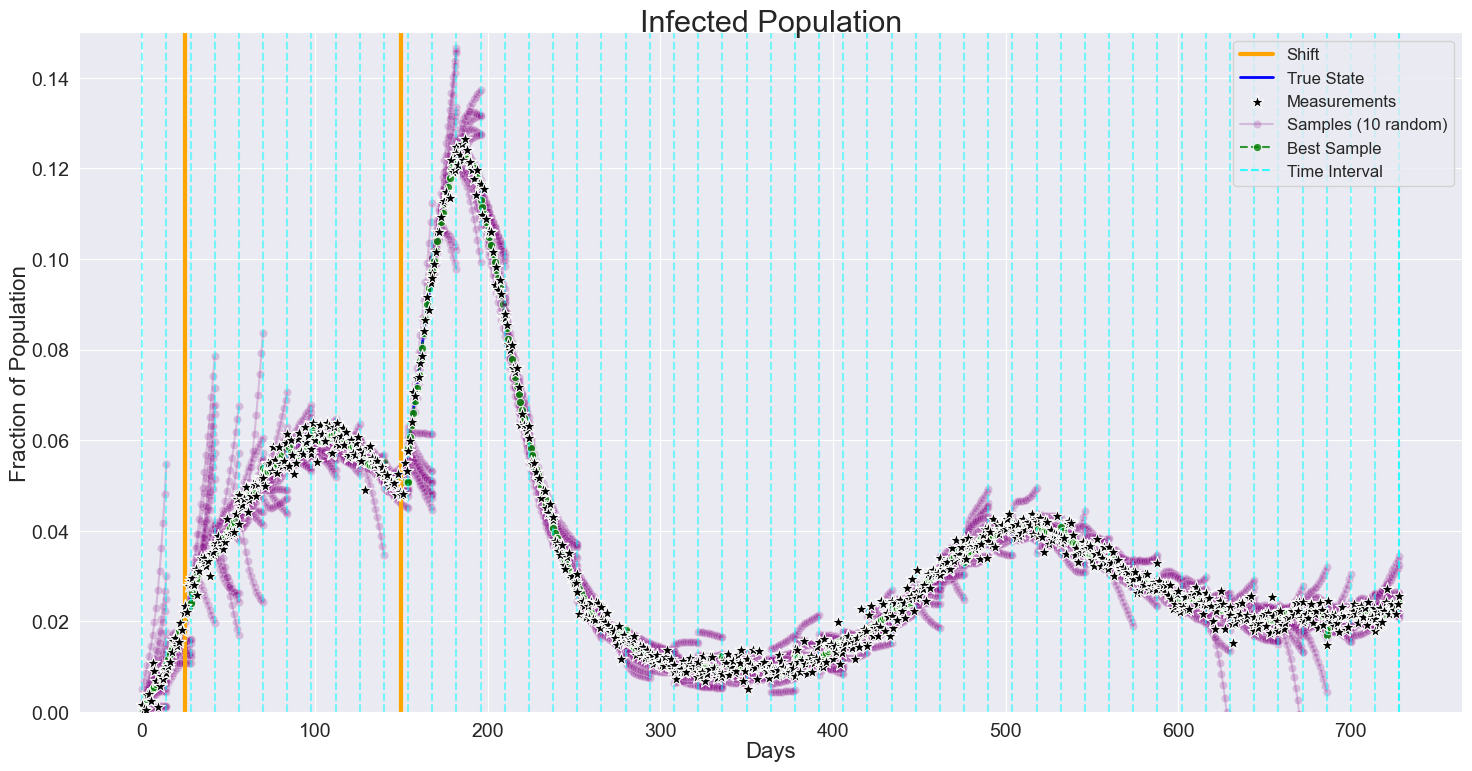

In [5]:
ax = prob.model.plot_infected(figsize=(15,8), n_samples=10)
ax.set_ylim([0, 0.15])

In [14]:
prob.results

,e_r,kl,k_eff,k_eff_up,solved,error,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,...,predict_delta,within_thresh,valid,closest,max_kl,min_kl,num_samples,weighted,data_idx,shift
0,1.064890,1.165099,1.0,0.674,True,None,0.091823,0.048413,0.014929,0.004186,...,0.064890,True,True,False,False,True,1000,False,0,False
0,1.053699,1.378902,1.0,0.628,True,None,0.125756,0.084810,0.047641,0.000646,...,0.053699,True,True,True,True,False,1000,False,0,False
0,0.681434,1.568474,1.0,0.617,False,Failed to solve problem on iteration 1 - |E(r)...,0.228080,0.095228,0.102136,0.004032,...,0.318566,True,False,False,False,False,1000,False,0,False
0,1.011087,1.969130,1.0,0.501,True,None,0.122931,0.119254,0.051051,0.002851,...,0.011087,True,True,True,False,True,1000,False,1,False
0,1.067143,2.809673,1.0,0.374,True,None,0.134990,0.168156,0.042119,0.004536,...,0.067143,True,True,False,False,False,1000,False,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.118659,0.942628,1.0,0.822,False,Failed to solve problem on iteration 1 - |E(r)...,0.466985,0.349895,0.099693,-0.014682,...,0.118659,True,False,False,False,False,1000,False,50,False
0,1.078322,0.973135,1.0,0.815,True,None,0.466985,0.349895,0.099693,-0.014682,...,0.078322,True,True,False,True,False,1000,False,50,False
0,1.060654,0.770884,1.0,0.834,True,None,0.396540,0.348089,0.093914,-0.007129,...,0.060654,True,True,False,False,True,1000,False,51,False
0,0.969902,1.850757,1.0,0.768,True,None,0.432276,0.503710,0.120083,0.008419,...,0.030098,True,True,True,True,False,1000,False,51,False


# First Shift

In [19]:
first_shift = [0, 80]

(-0.006328361694293439, 0.06)

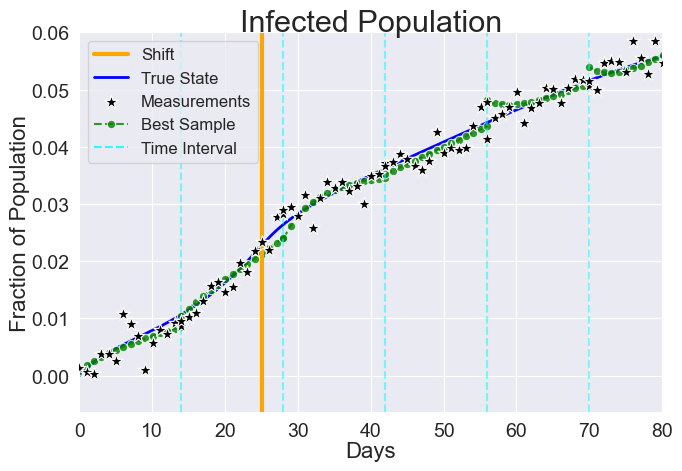

In [20]:
ax = sr.plot_infected(plot_samples=True, n_samples=0, figsize=(7, 5))
ax.set_xlim(first_shift)
ax.set_ylim([ax.get_ylim()[0], 0.06])

<AxesSubplot: xlabel='$\\lambda_1$', ylabel='Density'>

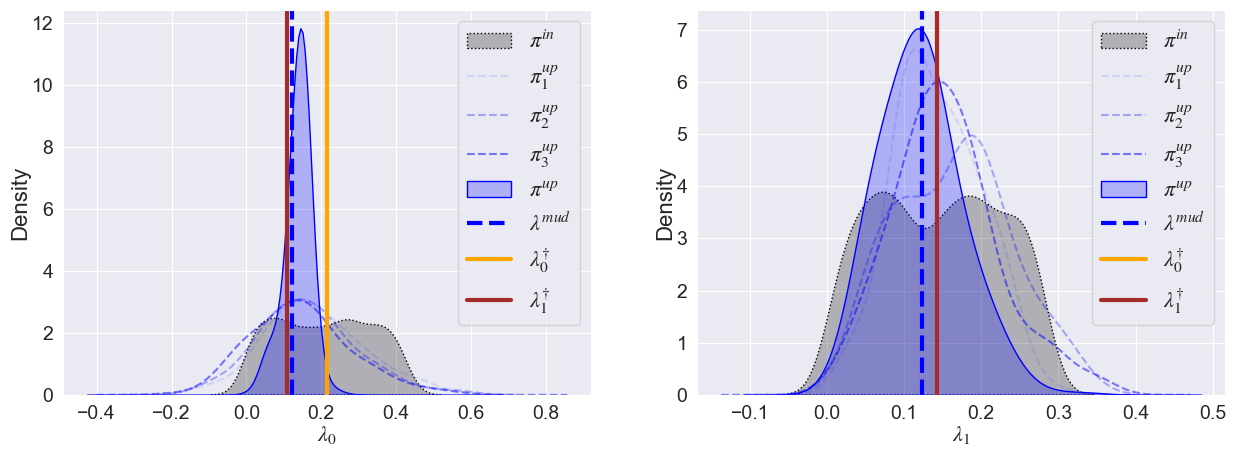

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
prob.plot_param_density(
    [p.best for p in prob.probs],
    param_idx=0,
    idxs=np.arange(0, int(first_shift[1] / data_chunk_size), 1),
    lam_true=[(0, SEIRS_P1), (1, SEIRS_P2)],
    ax=axs[0],
)
prob.plot_param_density(
    [p.best for p in prob.probs],
    param_idx=1,
    idxs=np.arange(0, int(first_shift[1]/ data_chunk_size), 1),
    lam_true=[(0, SEIRS_P1), (1, SEIRS_P2)],
    ax=axs[1],
)

# Second Shift

In [31]:
second_shift = [120, 200]

(-0.006328361694293439, 0.15)

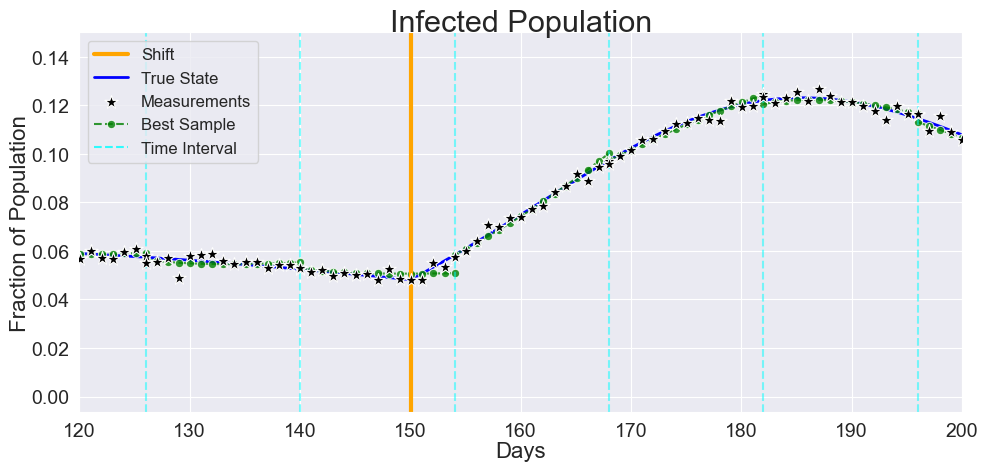

In [32]:
ax = sr.plot_infected(plot_samples=True, n_samples=0, figsize=(10, 5))
ax.set_xlim(second_shift)
ax.set_ylim([ax.get_ylim()[0], 0.15])

<AxesSubplot: xlabel='$\\lambda_1$', ylabel='Density'>

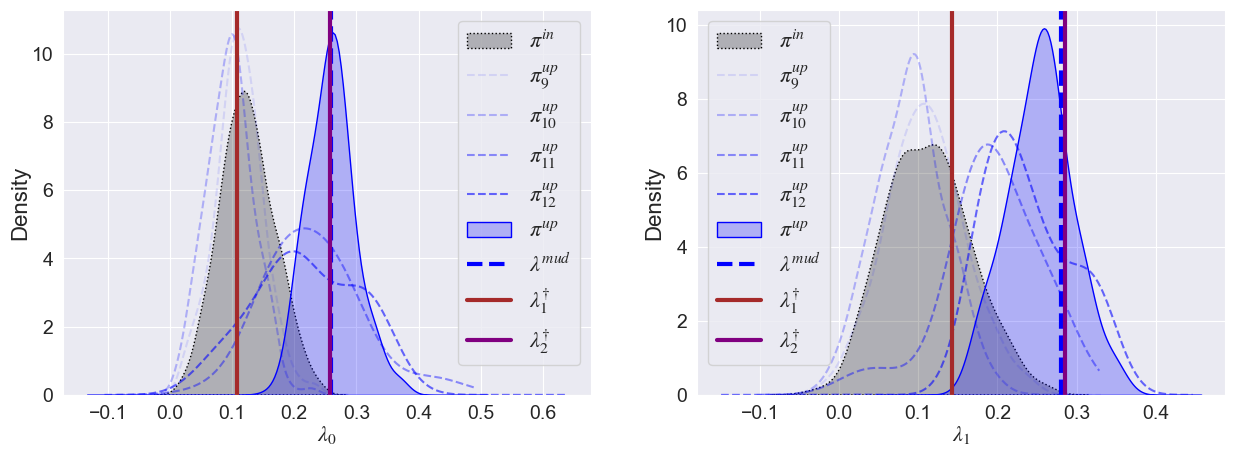

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
prob.plot_param_density(
    [p.best for p in prob.probs],
    param_idx=0,
    idxs=np.arange(int(second_shift[0]/ data_chunk_size), int(second_shift[1]/ data_chunk_size)),
    lam_true=[(1, SEIRS_P2), (2, SEIRS_P3)],
    ax=axs[0],
)
prob.plot_param_density(
    [p.best for p in prob.probs],
    param_idx=1,
    idxs=np.arange(int(second_shift[0]/ data_chunk_size), int(second_shift[1]/ data_chunk_size)),
    lam_true=[(1, SEIRS_P2), (2, SEIRS_P3)],
    ax=axs[1],
)

## Adaptive sampling performance when there is a shift

Note:
- We increase the value of e_r but can never get close to 1.0 because of shift.
- KL value decreases with more samples, but always way above threshold of 3

In [10]:
prob.it_results[22]

,e_r,kl,k_eff,k_eff_up,solved,error,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,...,predict_delta,within_thresh,valid,closest,max_kl,min_kl,num_samples,weighted,data_idx,shift
0,1.031934,0.878914,1.0,0.835000,False,Failed to solve problem on iteration 1 - |E(r)...,0.092241,0.116941,0.054465,0.003924,...,0.031934,True,False,False,False,False,1000,False,13,False
0,0.965091,2.684978,1.0,0.748000,False,Failed to solve problem on iteration 1 - |E(r)...,0.078566,0.203478,0.092068,0.003184,...,0.034909,True,False,False,False,False,1000,False,13,False
0,1.033018,0.889586,1.0,0.835455,False,Failed to solve problem on iteration 1 - |E(r)...,0.092241,0.116941,0.054465,0.003924,...,0.033018,True,False,False,False,False,1100,False,13,False
0,0.959752,2.657660,1.0,0.743636,False,Failed to solve problem on iteration 1 - |E(r)...,0.078566,0.203478,0.092068,0.003184,...,0.040248,True,False,False,False,False,1100,False,13,False
0,1.034993,0.877245,1.0,0.838333,False,Failed to solve problem on iteration 1 - |E(r)...,0.092241,0.116941,0.054465,0.003924,...,0.034993,True,False,False,False,False,1200,False,13,False
0,0.981481,2.566763,1.0,0.746667,False,Failed to solve problem on iteration 1 - |E(r)...,0.078566,0.203478,0.092068,0.003184,...,0.018519,True,False,False,False,False,1200,False,13,False
0,1.039089,0.832142,1.0,0.840000,False,Failed to solve problem on iteration 1 - |E(r)...,0.092241,0.116941,0.054465,0.003924,...,0.039089,True,False,False,False,False,1300,False,13,False
0,0.977401,2.525440,1.0,0.749231,False,Failed to solve problem on iteration 1 - |E(r)...,0.078566,0.203478,0.092068,0.003184,...,0.022599,True,False,False,False,False,1300,False,13,False
0,1.032899,0.846212,1.0,0.839286,False,Failed to solve problem on iteration 1 - |E(r)...,0.092241,0.116941,0.054465,0.003924,...,0.032899,True,False,False,False,False,1400,False,13,False
0,0.975223,2.527130,1.0,0.750000,False,Failed to solve problem on iteration 1 - |E(r)...,0.083385,0.149207,0.072411,0.004574,...,0.024777,True,False,False,False,False,1400,False,13,False


<AxesSubplot: xlabel='num_samples', ylabel='kl'>

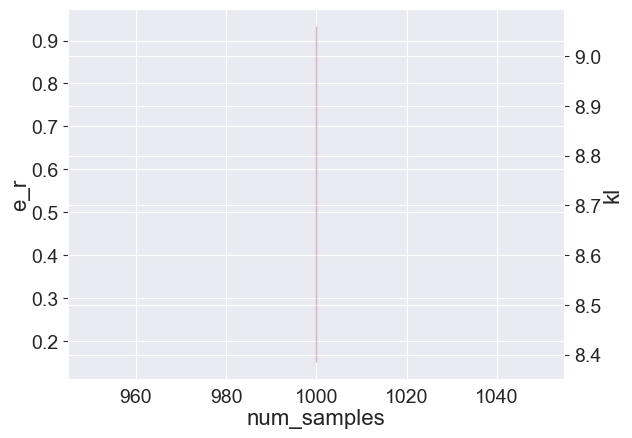

In [29]:
import seaborn as sns
ax = sns.lineplot(prob.it_results[22], x='num_samples', y='e_r')
ax2 = ax.twinx()
sns.lineplot(prob.it_results[22], x='num_samples', y='kl', ax=ax2, color='red')

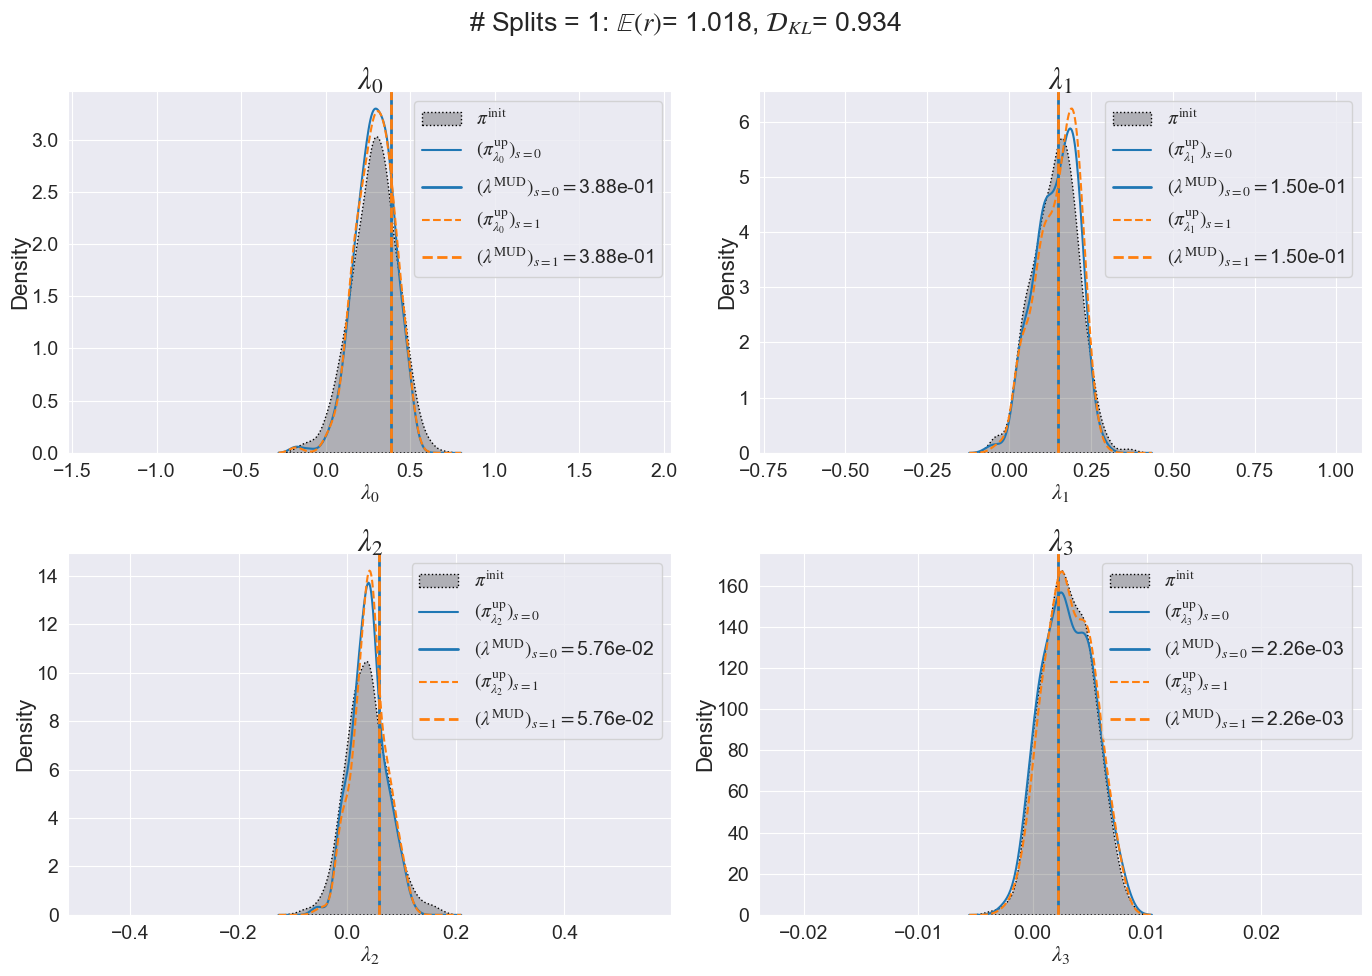

In [13]:
prob.probs[23].param_density_plots()

# OLD Code:

In [86]:
total_time = 1 * 365.25
max_nc = 1
data_chunk_size = 7
n_chunks = int(total_time / data_chunk_size)

sr = seirs.SEIRSModel(
    lam_true=SEIRS_P1,
    param_shifts=param_shifts,
    measurement_noise=SEIRS_NOISE,
    sample_ts=SEIRS_SAMPLE_TS,
    state_mins=SEIRS_STATE_MINS,
    state_maxs=SEIRS_STATE_MAXS,
)


set_seed(21)  # works well
# set_seed(2023) # Does not... why?
sgs, probs = sr.adaptive_online_iterative(
    np.arange(0, data_chunk_size * n_chunks + 1, data_chunk_size),
    diff=1.0,
    num_samples=1000,
    nc=1,
    resample_thresh=0.2,
    shift_thresh=0.5,
    min_eff_sample_size=0.8,
    weights=None,
)

Solving model sample set: |████▋               | ▂▄▆ 230/1000 [23%] in 0s (~0s, 

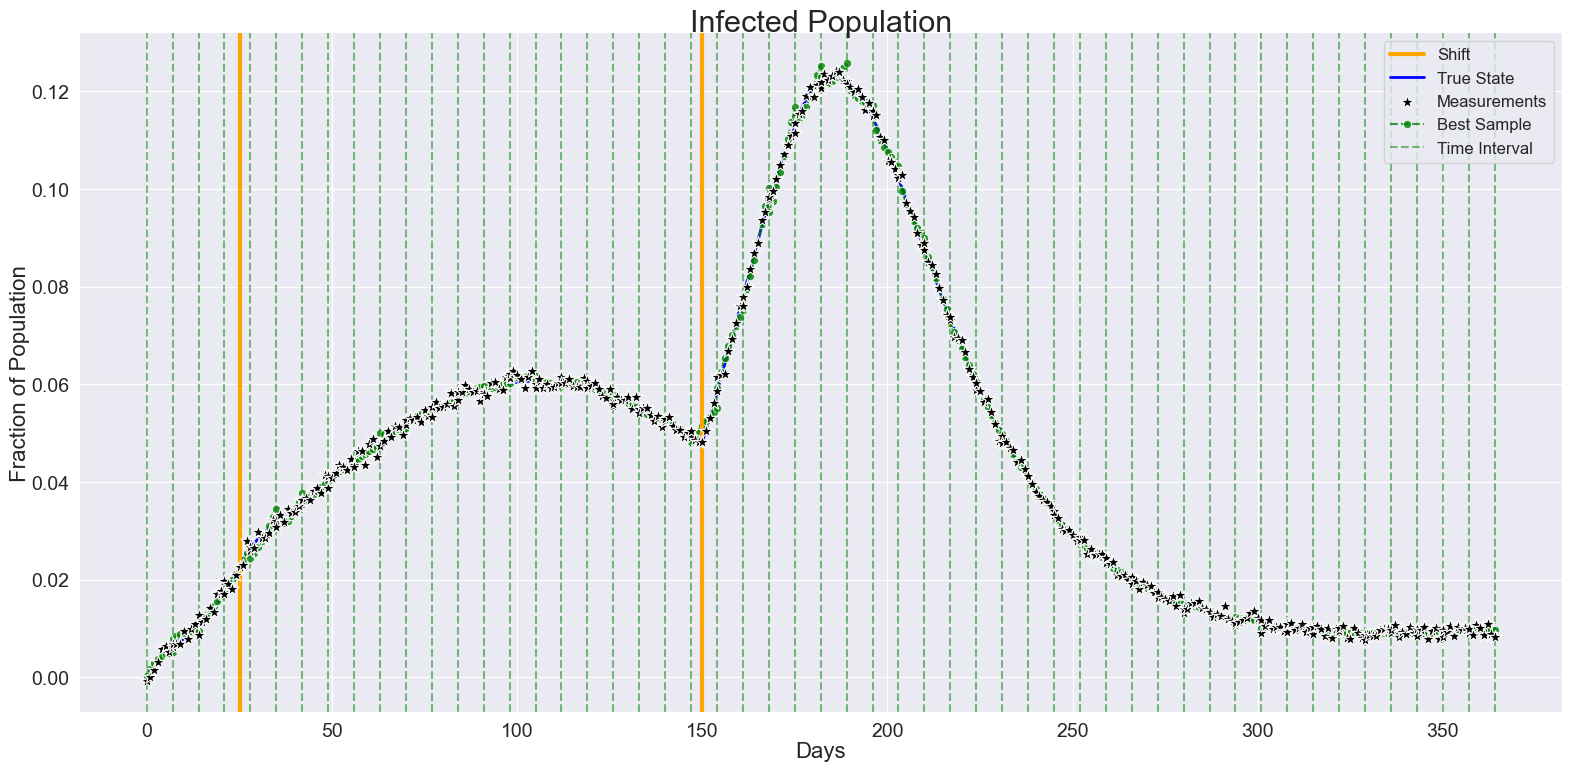

In [93]:
ax = sr.plot_infected(
    plot_measurements=True, plot_samples=True, n_samples=0, figsize=(16, 8)
)

## First Shift - "Flattening of the Curve"

In [88]:
first_shift_end = 100

(-0.007089759073479672, 0.08)

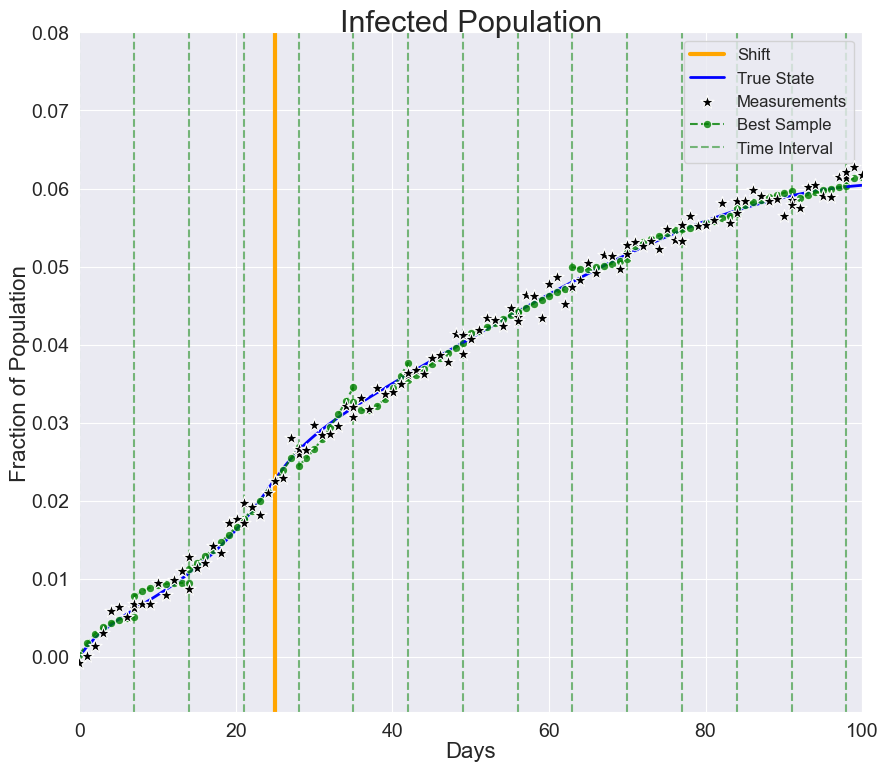

In [89]:
ax = sr.plot_infected(plot_samples=True, n_samples=0)
ax.set_xlim([0, first_shift_end])
ax.set_ylim([ax.get_ylim()[0], 0.08])

<AxesSubplot: xlabel='$\\lambda_1$', ylabel='Density'>

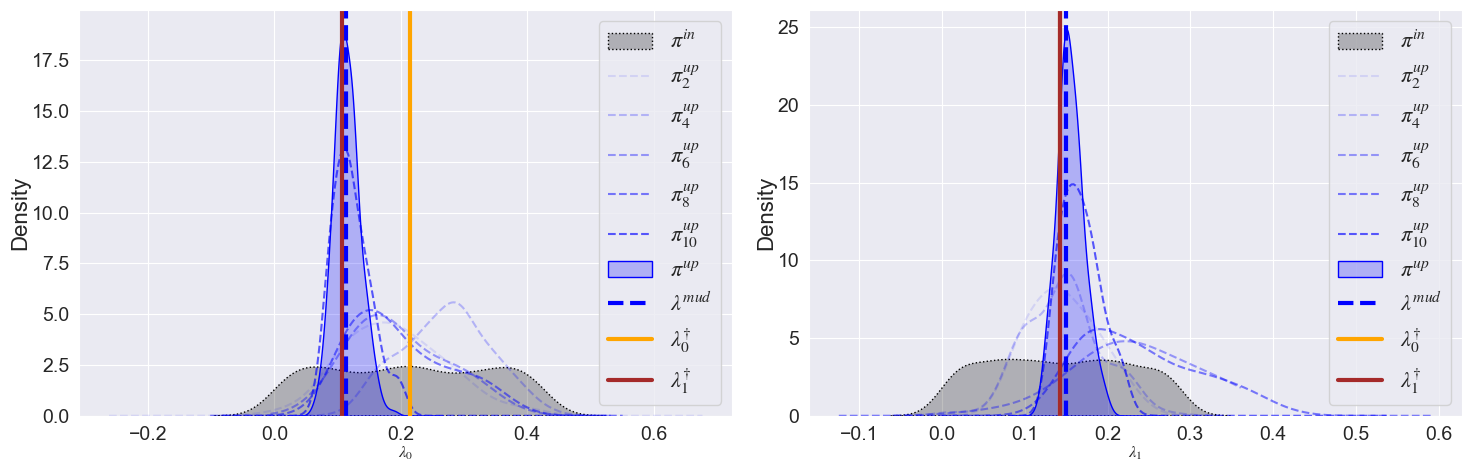

In [90]:
# TODO - Legend for parameter shift  ->
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sr.plot_param_density(
    probs,
    param_idx=0,
    idxs=np.arange(0, int(first_shift_end / 7), 2),
    lam_true=[(0, SEIRS_P1), (1, SEIRS_P2)],
    ax=axs[0],
)
sr.plot_param_density(
    probs,
    param_idx=1,
    idxs=np.arange(0, int(first_shift_end / 7), 2),
    lam_true=[(0, SEIRS_P1), (1, SEIRS_P2)],
    ax=axs[1],
)

## Second Shift - Mutation and "Second wave"

(120.0, 190.0)

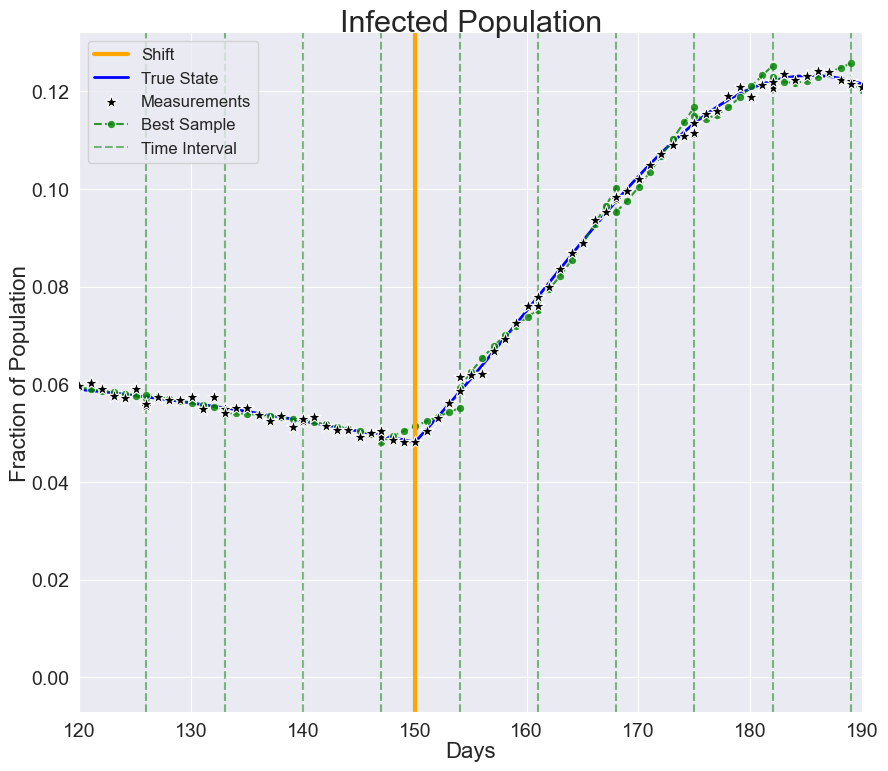

In [82]:
ax = sr.plot_infected(plot_samples=True, n_samples=0)
ax.set_xlim([120, 190])